In [1]:
%%capture

import os
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import euclidean
from scipy import stats
from tqdm import tqdm_notebook
import time


try:
    import ase
except:
    !pip install ase
    import ase
from ase import Atoms
import ase.visualize

In [2]:
DATA_DIR = '../input'

structure_dir = join(DATA_DIR, 'structures')
os.listdir(DATA_DIR)

['dipole_moments.csv',
 'potential_energy.csv',
 'magnetic_shielding_tensors.csv',
 'structures.csv',
 'scalar_coupling_contributions.csv',
 'structures',
 'sample_submission.csv',
 'mulliken_charges.csv',
 'test.csv',
 'train.csv']

# Data quantity

Total size: ~1GB  
(excluding the redundant 500MB from the structures folder (the same info is in structures.csv)

In [3]:
train = pd.read_csv(join(DATA_DIR, 'train.csv'))
test = pd.read_csv(join(DATA_DIR, 'test.csv'))
structures = pd.read_csv(join(DATA_DIR, 'structures.csv'))

print(f'number of structures: {len(os.listdir(structure_dir))}')
print(f'training interactions: {len(train)}')
print(f'test interactions: {len(test)}')
print(f'fraction of interactions used for testing: {round(len(test) / (len(test) + len(train)), 2)}')
train.head()

number of structures: 130775
training interactions: 4658147
test interactions: 2505542
fraction of interactions used for testing: 0.35


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


# Structures

In [4]:
assert len(structures.molecule_name.unique()) == len(os.listdir(structure_dir))
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


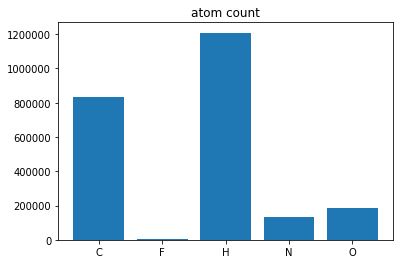

In [5]:
atom_count = structures.groupby('atom').size()
plt.bar(atom_count.index, atom_count.values)
plt.title('atom count');

#### 3D visualization

Most importantly, let's look at a few random molecules to get a rough idea about what we're dealing with.

The code for the 3D-visualization is from this cool kernel:  
https://www.kaggle.com/borisdee/how-to-easy-visualization-of-molecules  
Many thanks to the creator for sharing!

In [6]:
def view_molecule(structures=structures, name=None):
    """
    Modified from:
    https://www.kaggle.com/borisdee/how-to-easy-visualization-of-molecules
    """
    if name is None:
        name = np.random.choice(structures.molecule_name.unique())
    print(f'molecule-name: {name}')
    
    molecule_df = structures.query('molecule_name == @name')
    molecule    = Atoms(positions=molecule_df[['x', 'y', 'z']].values,
                        symbols=molecule_df.atom.values)
    
    return ase.visualize.view(molecule, viewer="x3d")


view_molecule(name=None)



molecule-name: dsgdb9nsd_048708


### Number of atoms per molecule

minimum number of atoms per molecule: 3
maximum number of atoms per molecule: 29


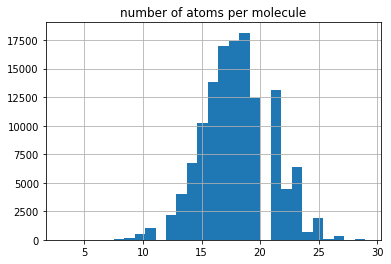

In [7]:
atom_counts = structures.groupby('molecule_name').size()
print(f'minimum number of atoms per molecule: {atom_counts.min()}')
print(f'maximum number of atoms per molecule: {atom_counts.max()}')
atom_counts.hist(bins=atom_counts.max())
plt.title('number of atoms per molecule');


number of traininig-structures: 85003


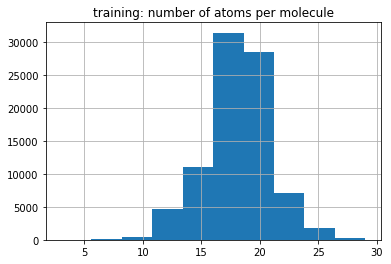

number of test-structures: 45772


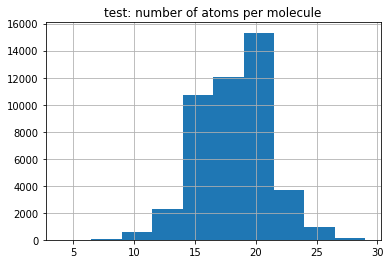

In [8]:
train_structures = structures[structures.molecule_name.isin(set(train.molecule_name))]
print(f'number of traininig-structures: {len(train_structures.molecule_name.unique())}')
train_counts = train_structures.groupby('molecule_name').size()
train_counts.hist()
plt.title('training: number of atoms per molecule')
plt.show()

test_structures = structures[structures.molecule_name.isin(set(test.molecule_name))]
print(f'number of test-structures: {len(test_structures.molecule_name.unique())}')
test_structures.groupby('molecule_name').size().hist()
plt.title('test: number of atoms per molecule');

# Number of labelled interactions per molecule

min and max number of j-couplings: 1, 135


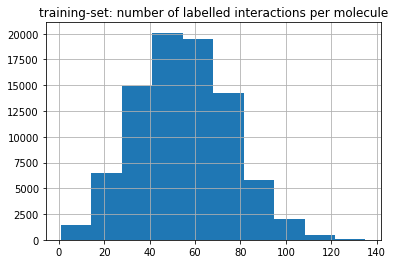

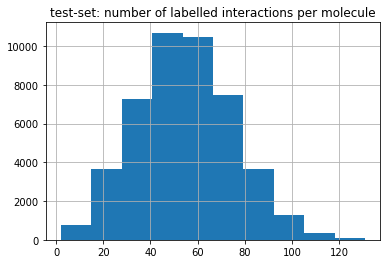

In [9]:
train_j_counts = train.groupby('molecule_name').size()
print(f'min and max number of j-couplings: {min(train_j_counts.values)}, {max(train_j_counts.values)}')
train_j_counts.hist()
plt.title('training-set: number of labelled interactions per molecule')
plt.show()

test.groupby('molecule_name').size().hist()
plt.title('test-set: number of labelled interactions per molecule');

### ...per coupling type

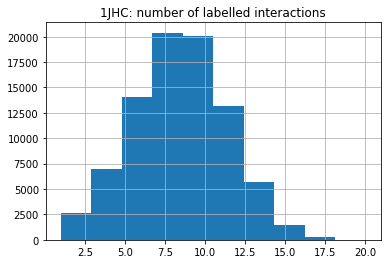

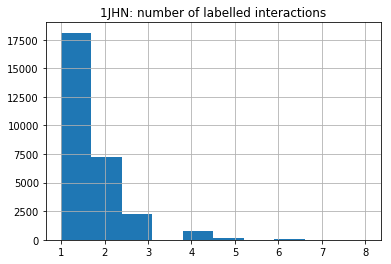

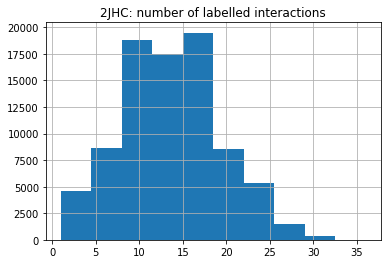

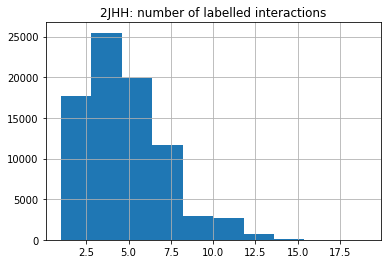

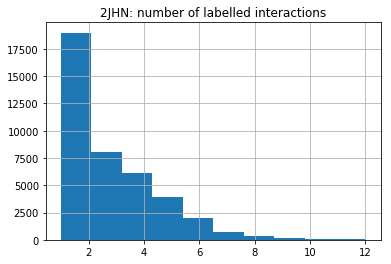

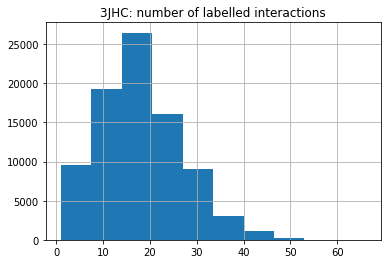

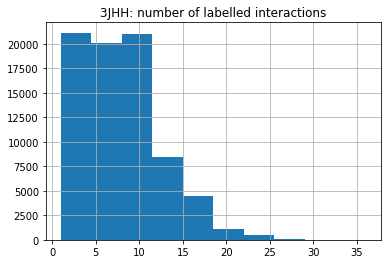

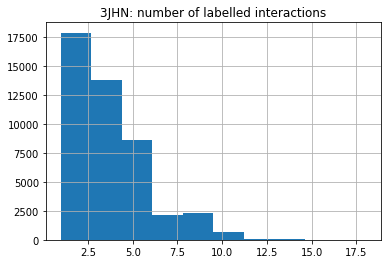

In [10]:
for sc_type, type_df in train.groupby('type'):
    counts = type_df.groupby('molecule_name').size()
    counts.hist()
    plt.title(f'{sc_type}: number of labelled interactions')
    plt.show()

# Target: scalar coupling constant

A measure of magnetic interaction between two atoms. Determined by the 3D environment of the atoms and measured with NMR.

The relationshipb between 3D structure and SCC is not trivial and requires expensive quantum mechanical calculations. Let's see if the relationship can be learned from data with a (graph) neural net.


In [11]:
sc_types = train.type.unique()
print(f'{len(sc_types)} scalar coupling types:\n{sorted(sc_types)}')
print(f'\nbonds-apart: {set(int(x[0]) for x in sc_types)}')
print(f'\nsc-interactions: {set(x[2:4] for x in sc_types)}')

8 scalar coupling types:
['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN']

bonds-apart: {1, 2, 3}

sc-interactions: {'HH', 'HN', 'HC'}


#### Number of interactions per scalar-coupling type

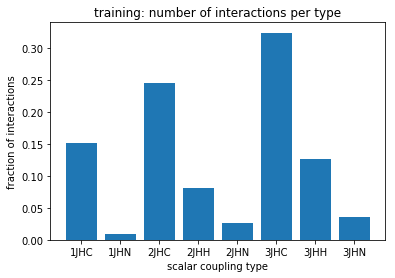

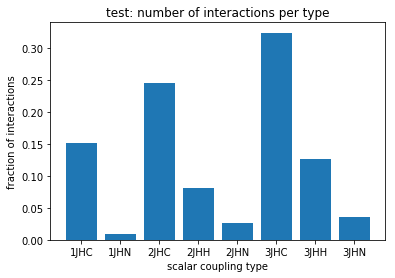

In [12]:
type_count = train.groupby('type').size() / len(train)
plt.bar(type_count.index, type_count.values)
plt.title('training: number of interactions per type')
plt.ylabel('fraction of interactions')
plt.xlabel('scalar coupling type')
plt.show()

type_count = test.groupby('type').size() / len(test)
plt.bar(type_count.index, type_count.values)
plt.ylabel('fraction of interactions')
plt.xlabel('scalar coupling type')
plt.title('test: number of interactions per type');

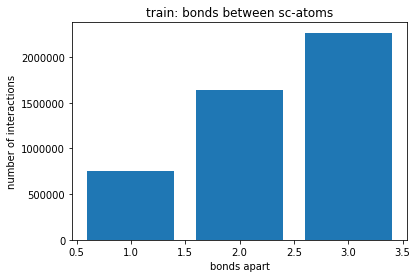

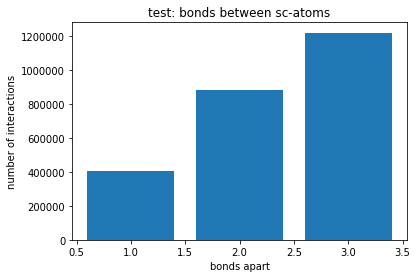

In [13]:
def add_sc_type_features(df):
    df['bonds']    = df.type.map(lambda x: int(x[0]))
    df['atom_pair'] = df.type.map(lambda x: x[2:4])
    return df


train = add_sc_type_features(train)
test  = add_sc_type_features(test)


bonds_counts = train.bonds.value_counts()
plt.bar(bonds_counts.index, bonds_counts.values)
plt.xlabel('bonds apart')
plt.ylabel('number of interactions')
plt.title('train: bonds between sc-atoms')
plt.show()

order_counts = test.bonds.value_counts()
plt.bar(order_counts.index, order_counts.values)
plt.xlabel('bonds apart')
plt.ylabel('number of interactions')
plt.title('test: bonds between sc-atoms')
plt.show()

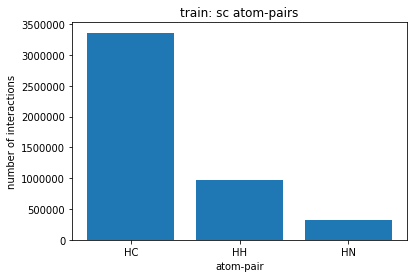

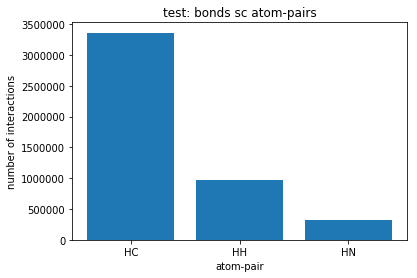

In [14]:
atom_pair_types = train.atom_pair.value_counts()
plt.bar(atom_pair_types.index, atom_pair_types.values)
plt.xlabel('atom-pair')
plt.ylabel('number of interactions')
plt.title('train: sc atom-pairs')
plt.show()

atom_pair_types = train.atom_pair.value_counts()
plt.bar(atom_pair_types.index, atom_pair_types.values)
plt.xlabel('atom-pair')
plt.ylabel('number of interactions')
plt.title('test: bonds sc atom-pairs')
plt.show()

#### Critical information:

The 8 scalar coupling types in this dataset have very different ranges of sc-constant!
=> The most straightforward guess would be to predict the median for each type. This would already be much better than just predicting the global median.

Also, that's the reason, why training a separate model for each type can pay off in this competition.

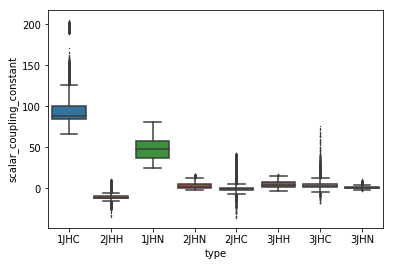

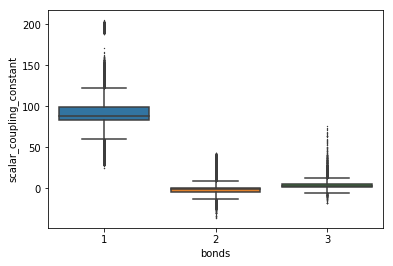

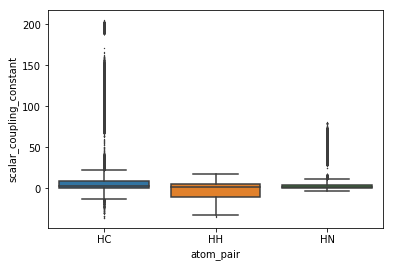

In [15]:
sns.boxplot(data=train, x='type', y='scalar_coupling_constant', fliersize=0.5)
plt.show();

sns.boxplot(data=train, x='bonds', y='scalar_coupling_constant', fliersize=0.5)
plt.show();

sns.boxplot(data=train, x='atom_pair', y='scalar_coupling_constant', fliersize=0.5)
plt.show();

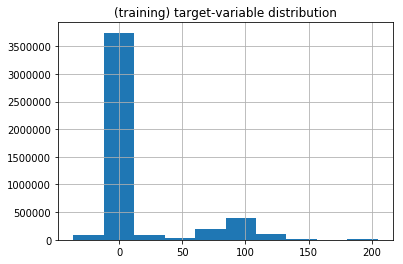

In [16]:
train.scalar_coupling_constant.hist()
plt.title('(training) target-variable distribution');

# Training-set Features

These features are provided only for the training set. I had a close look at them but ended up not using any of them for this competition.

### Molecule (graph-level) features

molecule dipole moment: https://en.wikipedia.org/wiki/Dipole#Molecular_dipoles

,molecule_name,X,Y,Z
0,dsgdb9nsd_000001,0.0000,0.0,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0,1.6256
2,dsgdb9nsd_000003,0.0000,0.0,-1.8511
3,dsgdb9nsd_000005,0.0000,0.0,-2.8937
4,dsgdb9nsd_000007,0.0000,0.0,0.0000


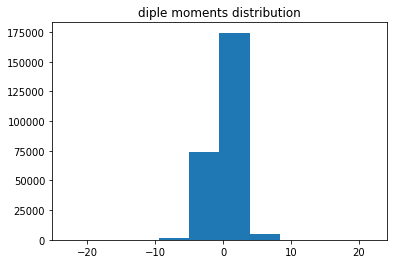

In [17]:
dipole = pd.read_csv(join(DATA_DIR, 'dipole_moments.csv'))
assert not set(dipole.molecule_name).intersection(test.molecule_name)

display(dipole.head())
plt.hist(dipole[['X', 'Y', 'Z']].values.ravel())
plt.title('diple moments distribution');

potential energy in molecules: https://www.quora.com/Where-is-potential-energy-stored-in-molecules

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.52368
1,dsgdb9nsd_000002,-56.56025
2,dsgdb9nsd_000003,-76.42608
3,dsgdb9nsd_000005,-93.42849
4,dsgdb9nsd_000007,-79.83869


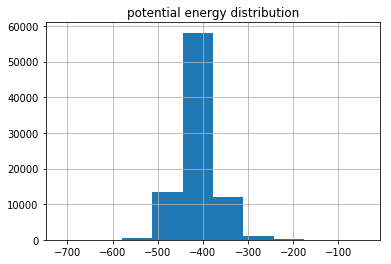

In [18]:
pot_energy = pd.read_csv(join(DATA_DIR, 'potential_energy.csv'))
assert not set(pot_energy.molecule_name).intersection(test.molecule_name)

display(pot_energy.head())
pot_energy.potential_energy.hist()
plt.title('potential energy distribution');

### Atom (node-leve) features

magnetic shield tensors: basically structural information obtaind from NMR  
Hence, the information should be more readily available from the structures directly.

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.3150,0.0000,-0.0001,0.0000,195.3170,0.0007,-0.0001,0.0007,195.3170
1,dsgdb9nsd_000001,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
2,dsgdb9nsd_000001,2,31.5814,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967
3,dsgdb9nsd_000001,3,31.5172,4.1086,1.2723,4.1088,33.9068,1.6950,1.2724,1.6951,28.9579
4,dsgdb9nsd_000001,4,31.4029,-4.0942,-1.1793,-4.0944,34.0776,1.6259,-1.1795,1.6260,28.9013


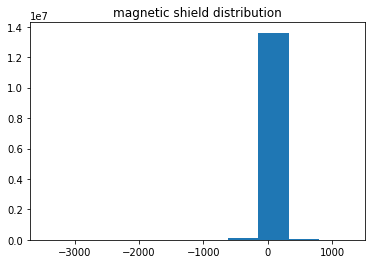

In [19]:
mag_shield = pd.read_csv(join(DATA_DIR, 'magnetic_shielding_tensors.csv'))
assert not set(mag_shield.molecule_name).intersection(test.molecule_name)

display(mag_shield.head())
plt.hist(mag_shield.drop(['molecule_name', 'atom_index'], axis=1).values.ravel())
plt.title('magnetic shield distribution');

Mulliken charge: https://en.wikipedia.org/wiki/Mulliken_population_analysis  
... basically parital charges of atoms. But dependent on the calculation method.

,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000001,0,-0.535689
1,dsgdb9nsd_000001,1,0.133921
2,dsgdb9nsd_000001,2,0.133922
3,dsgdb9nsd_000001,3,0.133923
4,dsgdb9nsd_000001,4,0.133923


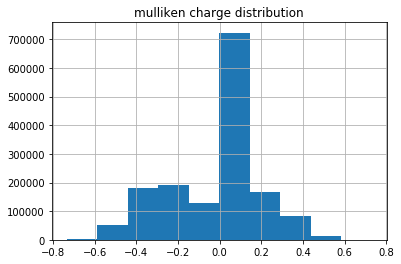

In [20]:
mulliken = pd.read_csv(join(DATA_DIR, 'mulliken_charges.csv'))
assert not set(mulliken.molecule_name).intersection(test.molecule_name)

display(mulliken.head())
mulliken.mulliken_charge.hist()
plt.title('mulliken charge distribution');

### Interaction (edge-level) features

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013


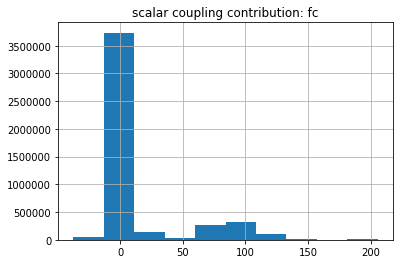

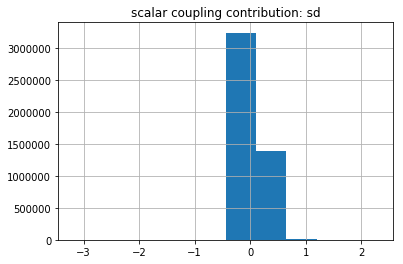

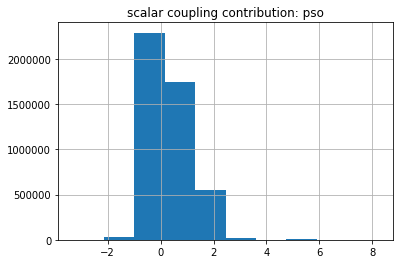

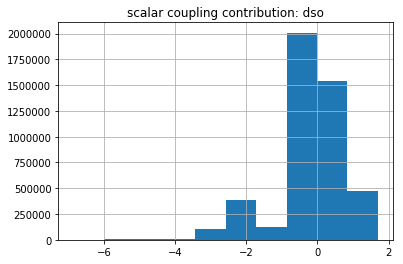

In [21]:
sc_contributions = pd.read_csv(join(DATA_DIR, 'scalar_coupling_contributions.csv'))
assert not set(sc_contributions.molecule_name).intersection(test.molecule_name)
display(sc_contributions.head())

for contribution in ('fc', 'sd', 'pso', 'dso'):
    sc_contributions[contribution].hist()
    plt.title(f'scalar coupling contribution: {contribution}')
    plt.show()

check that scalar coupling contributions add up to target variable:

In [22]:
sc = pd.merge(sc_contributions, train, on=('molecule_name', 'atom_index_0', 'atom_index_1', 'type'))
assert len(sc) == len(train) == len(sc_contributions)

sc['contribution_sum'] = sc.fc + sc.sd + sc.pso + sc.dso
sc['difference'] = (sc.scalar_coupling_constant - sc.contribution_sum).map(abs)
print('maximal differnce between sum of scalar coupling contributions and\nthe target variable '
      f'scalar coupling: {sc.difference.max()}')
sc.head()

maximal differnce between sum of scalar coupling contributions and
the target variable scalar coupling: 0.000994999999988977


,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso,id,scalar_coupling_constant,bonds,atom_pair,contribution_sum,difference
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010,0,84.8076,1,HC,84.807609,0.000009
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600,1,-11.2570,2,HH,-11.256932,0.000068
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870,2,-11.2548,2,HH,-11.254906,0.000106
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930,3,-11.2543,2,HH,-11.254346,0.000046
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013,4,84.8074,1,HC,84.807408,0.000008


# Distance distributions

Code from these 3 kernel is used for distance computations:  
https://www.kaggle.com/cpmpml/ultra-fast-distance-matrix-computation  
https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark  
https://www.kaggle.com/artgor/brute-force-feature-engineering

In [23]:
#Code in this cell is from this kernel:
#https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark

def map_atom_info(df, atom_idx, structures_df=structures):
    df = pd.merge(df, structures_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df


train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,bonds,atom_pair,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,HC,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,HH,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,2,HH,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,2,HH,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,HC,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


In [24]:
# code in this cell is from:
# https://www.kaggle.com/artgor/brute-force-feature-engineering

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

### Distances between atom-pairs with scalar coupling (target)

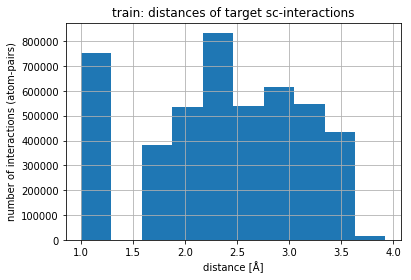

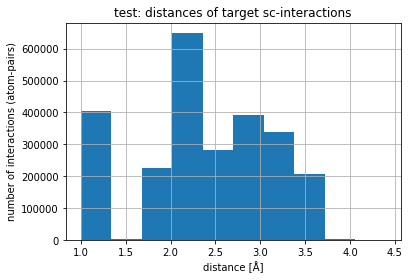

maximal sc-distance: 4.39


In [25]:
train.dist.hist()
plt.title('train: distances of target sc-interactions')
plt.xlabel('distance [Å]')
plt.ylabel('number of interactions (atom-pairs)');
plt.show()

test.dist.hist()
plt.title('test: distances of target sc-interactions')
plt.xlabel('distance [Å]')
plt.ylabel('number of interactions (atom-pairs)')
plt.show()

print(f'maximal sc-distance: {max(*train.dist, *test.dist):.2f}')

training-set:


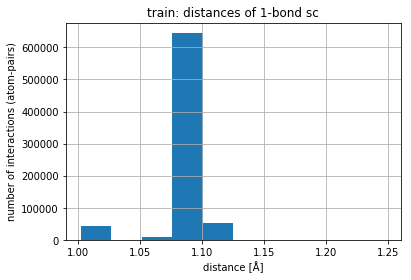

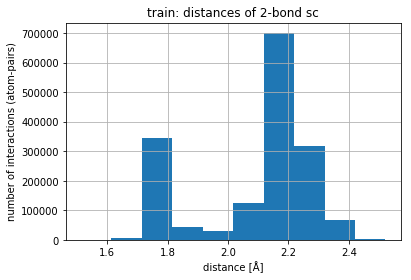

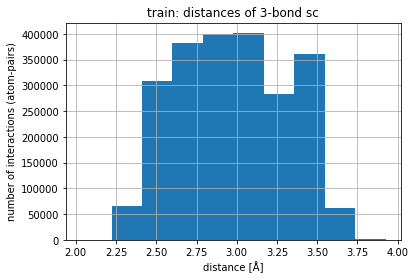

test-set:


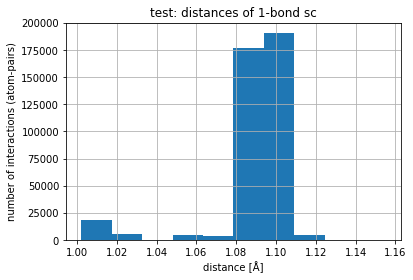

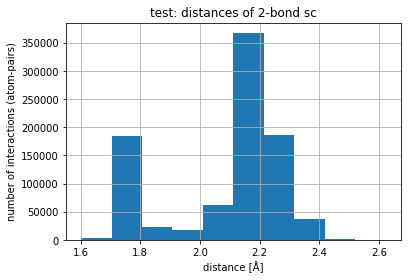

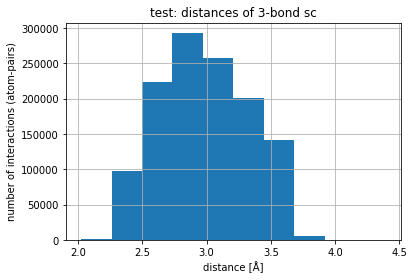

In [26]:
print('training-set:')
for n_bonds, df in train.groupby('bonds'):
    df.dist.hist()
    plt.title(f'train: distances of {n_bonds}-bond sc')
    plt.xlabel('distance [Å]')
    plt.ylabel('number of interactions (atom-pairs)');
    plt.show()
    
print('test-set:')
for n_bonds, df in test.groupby('bonds'):
    df.dist.hist()
    plt.title(f'test: distances of {n_bonds}-bond sc')
    plt.xlabel('distance [Å]')
    plt.ylabel('number of interactions (atom-pairs)');
    plt.show()

We can see a clear separation of one-bond j-coupled atoms and two-bond j-coupled atoms. This means that from euclidean distance alone, we could tell, whether the coupled atoms are one or two bonds apart.

Between 2-bond and 3-bond j-coupled atoms, there is a littel overlap. I.e. in the vast majority, the euclidean distance indicates whether two coupled atoms are two or three bonds apart. In a small number of cases, 2-bond and 3-bond coupled atoms can have similar euclidean distances. This is owed mostly to the different bond-angles resulting in different euclidean distnaces. Different bond lengths of different bond types (C-H vs. C-C, vs. N-H, etc.) also effect the euclidean distance. However, because bonds in organic molecules do not have vastly different lengths (~1-1.5 Angström), this effect is probably smaller than the effect of bond-angles.

All in all, euclidian distance pretty much includes the information of the number of bonds between two atoms (only for 1-3 bonds, of course) and vice versa.

### Maximum atom-atom distance within molecules
#### how much space do the molecules take up?

This information is only relevant if a 3D-conv-net trained directly on the 3D structure would be used.

In [27]:
def get_dist_matrix(df_structures_idx, molecule, bug_fixed=True):
    """
    Function from:
    https://www.kaggle.com/cpmpml/ultra-fast-distance-matrix-computation
    """
    df_temp = df_structures_idx.loc[molecule]
    locs = df_temp[['x','y','z']].values
    num_atoms = len(locs)
    loc_tile = np.tile(locs.T, (num_atoms,1,1))
    
    # bug fix: first: sum up the squares, THEN take the square root
    if bug_fixed:
        return np.sqrt( ((loc_tile - loc_tile.T)**2).sum(axis=1) )
    else:
        return np.sqrt( (loc_tile - loc_tile.T)**2 ).sum(axis=1)


mol_name2dist_matrix = {}
structures.index = structures.molecule_name

for mol_name in tqdm_notebook(structures.molecule_name.unique()):
    mol_name2dist_matrix[mol_name] = get_dist_matrix(structures, mol_name)

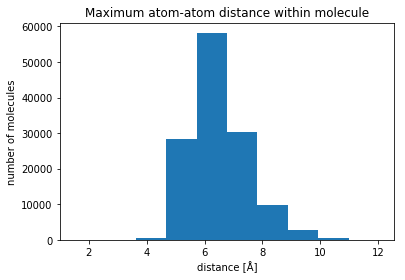

minimum atom-to-atom position (over all molecules): 0.9586


In [28]:
max_dists = [matrix.max() for matrix in mol_name2dist_matrix.values()]
plt.hist(max_dists)
plt.title('Maximum atom-atom distance within molecule')
plt.ylabel('number of molecules')
plt.xlabel('distance [Å]')
plt.show()

min_dist = min(matrix[matrix != 0].min() for matrix in mol_name2dist_matrix.values())
print(f'minimum atom-to-atom position (over all molecules): {min_dist:.4f}')

### Check distances

Just double- and triple- checking the distance computations... :-D

In [29]:
# distance unit-test:
structures_idx = structures.set_index('molecule_name')
molname = 'dsgdb9nsd_000001'

mdf = structures_idx.loc[molname]

#dist_matrix_bug   = get_dist_matrix(structures_idx, molname, bug_fixed=False)
dist_matrix_fixed = get_dist_matrix(structures_idx, molname)

a = mdf.iloc[0][['x', 'y', 'z']].values
b = mdf.iloc[1][['x', 'y', 'z']].values
display(mdf.head(2))

print('scipy-euclidian: ', euclidean(a, b))
print('numpy-norm: ', np.linalg.norm(a - b))
print('generic: ', np.sqrt(((a - b)**2).sum()))
#print("CPMP's calculation (bug): ", dist_matrix_bug[0, 1])
print("CPMP's calculation (fixed): ", dist_matrix_fixed[0, 1])

,atom_index,atom,x,y,z
molecule_name,,,,,
dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976


scipy-euclidian:  1.0919530596119005
numpy-norm:  1.0919530596119005
generic:  1.0919530596119005
CPMP's calculation (fixed):  1.0919530596119005
